# Loading the libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
from matplotlib import cm
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import string

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

* **Preparing the data generator**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:

data =[]
labels = []


**Normalizing the data before feeding to model**

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255)

**Loading data as 28 * 28 grayscale images**

In [7]:
train_generator = train_datagen.flow_from_directory(
    'F:\hand sign detection\hsd\Train',
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "sparse",
    color_mode='grayscale',
    subset = 'training'
    )

validation_generator = train_datagen.flow_from_directory(
    'F:\hand sign detection\hsd\Train',
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "sparse",
    color_mode='grayscale',
    subset = 'validation'
    )

test_generator = test_datagen.flow_from_directory(
    'F:\hand sign detection\hsd\Test',
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "sparse",
    color_mode='grayscale'
    )

Found 21974 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


# Class Labels
**24 classes excluding J and Z**

In [8]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]
print(classes, end = " ")

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] 

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
data = np.array(data) 
labels = np.array(labels)
print(data.shape, labels.shape) 
# (78418,30,30,3)(78418,)

(0,) (0,)


**Visualizing the dataset**

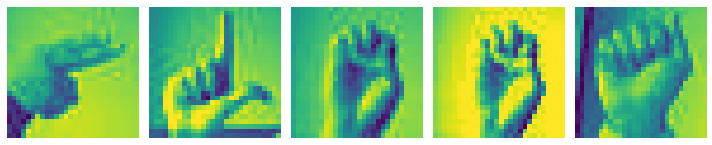

In [12]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

# **Preparing the CNN model**

In [13]:
import tensorflow as tf

**A small network of single convolution and 3 Dense layers**

In [14]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation = "relu", input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dense(len(classes), activation = "softmax")
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 256)               2769152   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 24)                6168      
                                                        

**Callback to stop training on 99.8% accuracy**

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("loss") < 0.004:
            print("\nReached 99.6% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

**Using RMSprop with learning rate = 0.01 and loss as categorical cross entropy**

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer = RMSprop(learning_rate = 0.001),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

# **Training**
**Training for 10 epochs**

In [34]:
history = model.fit(
    train_generator,
    epochs=10,
    callbacks = [callback],
    validation_data = validation_generator
)

Epoch 1/10
172/172 [==============================] - 237s 1s/step - loss: 1.7074 - accuracy: 0.5015 - val_loss: 0.6723 - val_accuracy: 0.8278
Epoch 2/10
172/172 [==============================] - 21s 122ms/step - loss: 0.3597 - accuracy: 0.8971 - val_loss: 0.2977 - val_accuracy: 0.9183
Epoch 3/10
172/172 [==============================] - 21s 123ms/step - loss: 0.0819 - accuracy: 0.9835 - val_loss: 0.1081 - val_accuracy: 0.9823
Epoch 4/10
172/172 [==============================] - 22s 126ms/step - loss: 0.0278 - accuracy: 0.9943 - val_loss: 0.0132 - val_accuracy: 0.9991
Epoch 5/10
172/172 [==============================] - 22s 125ms/step - loss: 0.0159 - accuracy: 0.9965 - val_loss: 0.0093 - val_accuracy: 0.9984
Epoch 6/10
172/172 [==============================] - 22s 126ms/step - loss: 0.0104 - accuracy: 0.9981 - val_loss: 8.6215e-04 - val_accuracy: 1.0000
Epoch 7/10
172/172 [==============================] - 21s 122ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 2.7537e-04 - 

In [35]:
model.save("F:/hand sign detection/hsd.h5")

# **Evaluating**
**Testing the model on unseen dataset of 7k images**

In [36]:
results = model.evaluate(test_generator)

57/57 [==============================] - 47s 829ms/step - loss: 1.0937 - accuracy: 0.8550


# **Visualizing the results**

In [37]:
# PLOT LOSS AND ACCURACY
# %matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

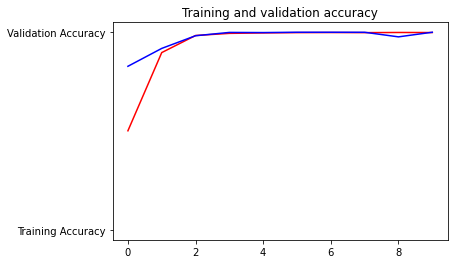

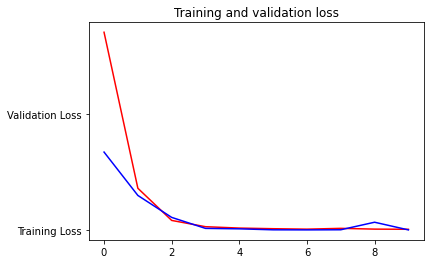

In [38]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

# **Predicting**
**Randomly choose an alphabet from folder and display its prediction**

In [39]:
from random import randint
import cv2 as cv

def testModel(alphabet = "p"):
    dirname, _, filenames = list(os.walk(f'F:/hand sign detection/hsd/Test/{alphabet.upper()}'))[0]
    img_path = os.path.join(dirname, filenames[randint(0, len(filenames))])
    print(img_path)
    img = cv.imread(img_path, 0).reshape(1, 28, 28, 1)
    pred = model.predict(img)
    pred_label = classes[np.argmax(pred)]
    

    plt.title(pred_label)
    plt.imshow(img[0,:,:,0], cmap = "gray")

F:/hand sign detection/hsd/Test/D\262_D.jpg


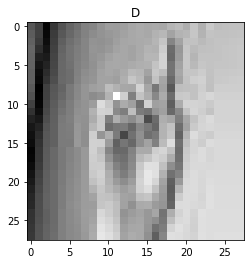

In [42]:
testModel("d")

In [41]:
model.save("F:/hand sign detection/training/hsd.h5")